In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as pp
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [3]:
import pandas as pd
import nltk as nltk
import string

from time import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering

# Business Description Data
## SP500 Data

In [4]:
my_path = Path('/Users/brandon/Documents/UCL/COMP0087/CW2/SP500')
os.chdir(my_path)
fns = os.listdir(my_path)

ticker_sp50 = []
sector_sp50 = []
bds_sp50 = []
for fn in fns:
    fn_first = fn.split('.txt')[0]
    ticker = fn_first.split('_')[0]
    sector = fn_first.split('_')[1]
    f = open(fn, 'r', encoding="utf8")
    f_text = f.read()
    f.close()
    
    ticker_sp50.append(ticker)
    sector_sp50.append(sector)
    bds_sp50.append(f_text)

## Larger Dataset - excluding SP500

In [5]:
os.chdir(Path('/Users/brandon/Documents/UCL/COMP0087/CW2'))
f = open("bds_1.txt", "r", encoding="utf8")
f_lines = f.readlines()
f.close()

company_ids_all = f_lines[0::2]
company_descriptions_all = f_lines[1::2]
company_tickers = [x.split(':')[0] for x in company_ids_all]
removeSP = np.in1d(np.array(company_tickers), list(ticker_sp50))

bds_all = []
ticker_all = []
for i, d in enumerate(company_descriptions_all):
    if (len(d) > 3000) and not removeSP[i]:
        bds_all.append(d)
        ticker_all.append(company_ids_all[i])

# Get Returns Data

In [6]:
start_d = np.datetime64('2018-01-01')
end_d = np.datetime64('2020-01-01')
business_ds = pd.date_range(start_d, end_d, freq='B')

my_path = Path('/Users/brandon/Documents/UCL/COMP0087/CW2')
os.chdir(my_path)
price_data = pd.read_csv('Price.csv')

select_these = np.in1d(price_data.tic.values, list(ticker_sp50))
price_sp50 = price_data.loc[select_these, ['tic', 'datadate', 'prccd']]
price_sp50['datadate'] = pd.to_datetime(price_sp50['datadate'], format='%Y%m%d')
price_sp50 = pd.pivot_table(price_sp50,index='datadate',columns='tic',values='prccd')
price_sp50 = price_sp50.ffill(limit=5)
price_sp50 = price_sp50.reindex(business_ds)
price_sp50 = price_sp50.dropna(axis=0)

returns_sp50 = np.log(price_sp50) - np.log(price_sp50.shift(1))
returns_sp50 = returns_sp50.dropna(axis=0)

/Users/brandon/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# KMeans on S&P500

In [11]:
#Instance of Lemmatizer
lemmatizer = WordNetLemmatizer()

## Pre-processing larger dataset

In [12]:
#preprocess larger dataset
t0 = time()
#Remove puncuation
bds_all2 = bds_all[:]
for i in range(len(bds_all)):
    for k in string.punctuation:
        bds_all2[i] = bds_all2[i].replace(k, '')

#Tokenise and remove stopwords
tokenised = []
for i in range(len(bds_all2)):
    text = bds_all2[i].split()
    text = [word.lower() for word in text if not word.lower() in stopwords.words('english')]
    tokenised.append(text)

#Lemmatizes each word
lemmad_text = []
for i in range(len(tokenised)): #CHANGE THIS
# for i in range(1):
    print(i)
    lemmad_array = tokenised[i]
    lemmad = [lemmatizer.lemmatize(word.lower()) for word in lemmad_array]
    lemmad = ' '.join(lemmad)
    lemmad_text.append(lemmad)

print("done in %fs" % (time() - t0))
print(lemmad_text[0])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
done in 3001.805637s
medallion financial corp company finance company organized delaware corporation includes medallion bank primary operating subsidiary recent year strategic growth medallion bank originates consumer loan purchase recreational vehicle boat trailer finance smallscale home improvement historically leading position originating acquiring servicing loan finance taxi medallion various type commercial business since medallion bank acquired consumer loan portfolio began originating consumer loan 2004 increased consumer loan portfolio compound annual growth rate 16 19 loan sale 2016 2017 2018 january 2017 announced plan transform overall strategy transitioned away medallion lending placed strategic focus growing consumer finance portfolio total asset management includes asset serviced third party investor 1660000000 december 31 2019 1522000000 december 31 2018 grown co

## Pre-processing S&P500

In [13]:
#preprocess sp500
t0 = time()
#Remove puncuation
bds_sp50_2 = bds_sp50[:]
for i in range(len(bds_sp50_2)):
    for k in string.punctuation:
        bds_sp50_2[i] = bds_sp50_2[i].replace(k, '')

#Tokenise and remove stopwords
tokenised_sp50 = []
for i in range(len(bds_sp50_2)):
    text = bds_sp50_2[i].split()
    text = [word.lower() for word in text if not word.lower() in stopwords.words('english')]
    tokenised_sp50.append(text)

#Lemmatizes each word
lemmad_text_sp50 = []
for i in range(len(tokenised_sp50)): #CHANGE THIS
# for i in range(1):
    print(i)
    lemmad_array = tokenised_sp50[i]
    lemmad = [lemmatizer.lemmatize(word.lower()) for word in lemmad_array]
    lemmad = ' '.join(lemmad)
    lemmad_text_sp50.append(lemmad)

print("done in %fs" % (time() - t0))
print(lemmad_text_sp50[0])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Get Features

In [14]:
cv_lem = CountVectorizer()
X_lemmad = cv_lem.fit_transform(lemmad_text)
print(X_lemmad.shape)

(1891, 175805)


## Train Kmeans using elbow method to find best k based on inertia

Initialization complete
Iteration 0, inertia 500378013.0
Iteration 1, inertia 446068443.242731
Converged at iteration 1: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 738044638.0
Iteration 1, inertia 446068443.242731
Converged at iteration 1: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 1010288045.0
Iteration 1, inertia 446068443.242731
Converged at iteration 1: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 871434330.0
Iteration 1, inertia 446068443.242731
Converged at iteration 1: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 622236414.0
Iteration 1, inertia 446068443.242731
Converged at iteration 1: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 566122352.0
Iteration 1, inertia 446068443.242731
Converged at i

Iteration 11, inertia 282138716.409282
Iteration 12, inertia 282133027.3661055
Iteration 13, inertia 282130778.2373314
Iteration 14, inertia 282127431.8525292
Iteration 15, inertia 282122419.8772925
Iteration 16, inertia 282119634.20860106
Iteration 17, inertia 282113373.7731992
Iteration 18, inertia 282111020.06566167
Converged at iteration 18: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 373041275.0
Iteration 1, inertia 284259219.2840362
Iteration 2, inertia 279432514.2178002
Iteration 3, inertia 276128111.432926
Iteration 4, inertia 274081519.42288667
Iteration 5, inertia 273084296.5989291
Iteration 6, inertia 271922701.7369761
Iteration 7, inertia 271334983.0031739
Iteration 8, inertia 271291085.2669325
Iteration 9, inertia 271284391.61421174
Iteration 10, inertia 271283678.9809262
Converged at iteration 10: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 383767809.0
Itera

Iteration 12, inertia 213461918.91722822
Iteration 13, inertia 213458020.52369297
Iteration 14, inertia 213455525.0447026
Iteration 15, inertia 213454797.49177277
Converged at iteration 15: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 374713157.0
Iteration 1, inertia 226487591.45665753
Iteration 2, inertia 224197984.7789088
Iteration 3, inertia 222326095.09192726
Iteration 4, inertia 220262764.7698705
Iteration 5, inertia 217400996.77931902
Iteration 6, inertia 215029117.58782494
Iteration 7, inertia 213986450.1358995
Iteration 8, inertia 213592710.93332532
Iteration 9, inertia 213497622.10604137
Iteration 10, inertia 213479599.50413162
Iteration 11, inertia 213462659.0952908
Iteration 12, inertia 213458822.22959796
Iteration 13, inertia 213456351.73996907
Iteration 14, inertia 213455600.9841126
Iteration 15, inertia 213454797.49177277
Converged at iteration 15: center shift 0.0 within tolerance 0.00013417720752205588
Initializat

Iteration 10, inertia 204407753.37948763
Iteration 11, inertia 204304737.47020677
Iteration 12, inertia 204242642.17215037
Iteration 13, inertia 204224571.34663782
Iteration 14, inertia 204223519.09309784
Iteration 15, inertia 204222803.48976737
Iteration 16, inertia 204222252.16791037
Iteration 17, inertia 204221551.8410833
Iteration 18, inertia 204221127.22896543
Converged at iteration 18: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 283138355.0
Iteration 1, inertia 223826968.45416927
Iteration 2, inertia 219111912.60406134
Iteration 3, inertia 207935813.18887112
Iteration 4, inertia 204511302.64345023
Iteration 5, inertia 203924076.5237541
Iteration 6, inertia 203825867.95330596
Iteration 7, inertia 203731347.00898856
Iteration 8, inertia 203626288.28516555
Iteration 9, inertia 203567541.2950396
Converged at iteration 9: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 27488

Iteration 19, inertia 172277065.8000936
Iteration 20, inertia 172268010.5334685
Iteration 21, inertia 172235372.53061453
Iteration 22, inertia 172222013.12739098
Iteration 23, inertia 172219765.40057886
Iteration 24, inertia 172219105.6748537
Iteration 25, inertia 172218791.99123123
Converged at iteration 25: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 228143734.0
Iteration 1, inertia 181551456.5791004
Iteration 2, inertia 180960850.78330433
Iteration 3, inertia 180881853.13702154
Iteration 4, inertia 180825681.85387334
Iteration 5, inertia 180824517.04673964
Converged at iteration 5: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 243999998.0
Iteration 1, inertia 173957003.5233719
Iteration 2, inertia 173173292.6472508
Iteration 3, inertia 172629011.104021
Iteration 4, inertia 172616821.52022913
Converged at iteration 4: center shift 0.0 within tolerance 0.000134177207522055

Iteration 13, inertia 169948535.3364101
Iteration 14, inertia 169942356.67419985
Iteration 15, inertia 169941894.64440486
Iteration 16, inertia 169941002.1211008
Converged at iteration 16: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 274489052.0
Iteration 1, inertia 204574872.50732294
Iteration 2, inertia 202758917.50050136
Iteration 3, inertia 201561301.02173182
Iteration 4, inertia 198609210.72005907
Iteration 5, inertia 197717651.42429873
Iteration 6, inertia 197534640.5263425
Iteration 7, inertia 197430456.32434303
Iteration 8, inertia 197258057.27498373
Iteration 9, inertia 197076302.88876382
Iteration 10, inertia 196969139.7517991
Iteration 11, inertia 196890528.39423558
Iteration 12, inertia 196850434.0584604
Iteration 13, inertia 196818541.40475994
Iteration 14, inertia 196803451.04442868
Iteration 15, inertia 196797745.34834135
Iteration 16, inertia 196788686.61723763
Iteration 17, inertia 196784705.01243874
Iteration 18

Initialization complete
Iteration 0, inertia 241297592.0
Iteration 1, inertia 174988617.47434387
Iteration 2, inertia 169989223.94561014
Iteration 3, inertia 168672852.7703564
Iteration 4, inertia 168043483.57652807
Iteration 5, inertia 166876894.12557274
Iteration 6, inertia 165151213.57945514
Iteration 7, inertia 163408141.56732795
Iteration 8, inertia 162655075.38875875
Iteration 9, inertia 162451248.76132056
Iteration 10, inertia 162388011.57630345
Iteration 11, inertia 162356794.6508044
Iteration 12, inertia 162317960.36034766
Iteration 13, inertia 162257373.98144516
Iteration 14, inertia 162203618.30031812
Iteration 15, inertia 162157266.06049022
Iteration 16, inertia 162024240.99356365
Iteration 17, inertia 161941759.8600649
Iteration 18, inertia 161890582.32638896
Iteration 19, inertia 161881715.49408218
Iteration 20, inertia 161878344.50947398
Iteration 21, inertia 161877908.33945963
Converged at iteration 21: center shift 0.0 within tolerance 0.00013417720752205588
Initializa

Iteration 14, inertia 154387251.0847002
Iteration 15, inertia 154337674.48913231
Iteration 16, inertia 154309264.0901342
Iteration 17, inertia 154299380.3047939
Iteration 18, inertia 154292378.79601657
Iteration 19, inertia 154284685.83826724
Iteration 20, inertia 154280369.5131772
Iteration 21, inertia 154278625.21390107
Iteration 22, inertia 154278181.5624044
Iteration 23, inertia 154278031.1380839
Converged at iteration 23: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 239703961.0
Iteration 1, inertia 172635457.17940208
Iteration 2, inertia 167109760.05665484
Iteration 3, inertia 165115082.34994733
Iteration 4, inertia 163809692.97496045
Iteration 5, inertia 161784719.6722664
Iteration 6, inertia 160486057.4288527
Iteration 7, inertia 159572239.20982924
Iteration 8, inertia 159207429.74515224
Iteration 9, inertia 159094714.00213173
Iteration 10, inertia 159066011.61565945
Iteration 11, inertia 159059243.37912977
Iteration 12, i

Iteration 6, inertia 149829167.21073464
Iteration 7, inertia 149762281.121513
Iteration 8, inertia 149704310.0491312
Iteration 9, inertia 149686225.18445414
Iteration 10, inertia 149639204.9849299
Iteration 11, inertia 149592076.3811796
Iteration 12, inertia 149528175.00533292
Iteration 13, inertia 149446298.26479855
Iteration 14, inertia 149365671.8960471
Iteration 15, inertia 149188901.03926992
Iteration 16, inertia 149061941.43494025
Iteration 17, inertia 149035675.29503262
Iteration 18, inertia 149029380.61596844
Iteration 19, inertia 149021749.94910327
Iteration 20, inertia 149016532.9217522
Iteration 21, inertia 149014520.69536477
Iteration 22, inertia 149013872.81745145
Iteration 23, inertia 149013721.2791103
Converged at iteration 23: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 219421426.0
Iteration 1, inertia 160095465.75337297
Iteration 2, inertia 156786894.4321501
Iteration 3, inertia 155913519.6739491
Iteration 4, in

Initialization complete
Iteration 0, inertia 225462804.0
Iteration 1, inertia 154869161.4177885
Iteration 2, inertia 151548355.75301075
Iteration 3, inertia 147725779.2071037
Iteration 4, inertia 145820226.6334871
Iteration 5, inertia 145681573.97333503
Iteration 6, inertia 145644410.11723068
Iteration 7, inertia 145639068.79454044
Converged at iteration 7: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 215227382.0
Iteration 1, inertia 153120600.01480183
Iteration 2, inertia 149930275.36777645
Iteration 3, inertia 149345671.6337499
Iteration 4, inertia 149120114.07257912
Iteration 5, inertia 149043509.7415383
Iteration 6, inertia 148979308.76694304
Iteration 7, inertia 148920895.67163172
Iteration 8, inertia 148861851.14117754
Iteration 9, inertia 148802482.92406577
Iteration 10, inertia 148751417.32692146
Iteration 11, inertia 148739405.79125953
Iteration 12, inertia 148734657.2012416
Iteration 13, inertia 148704976.97092694
Itera

Iteration 8, inertia 145551341.9076029
Iteration 9, inertia 145331754.085538
Iteration 10, inertia 145225083.5721099
Iteration 11, inertia 145099649.74884614
Iteration 12, inertia 144987086.84299105
Iteration 13, inertia 144894226.27243704
Iteration 14, inertia 144830887.27436823
Iteration 15, inertia 144811313.32422262
Iteration 16, inertia 144777589.60266292
Iteration 17, inertia 144758974.58287153
Iteration 18, inertia 144741409.7081724
Iteration 19, inertia 144711531.55503014
Iteration 20, inertia 144695844.09837428
Iteration 21, inertia 144561633.31295085
Iteration 22, inertia 144163456.76693895
Iteration 23, inertia 144141836.8373144
Iteration 24, inertia 144139982.2331496
Iteration 25, inertia 144135697.61303377
Iteration 26, inertia 144130888.83570978
Iteration 27, inertia 144121886.37540978
Iteration 28, inertia 144114262.50433508
Converged at iteration 28: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 211344874.0
Iterati

Iteration 12, inertia 145227414.90690753
Iteration 13, inertia 144709442.72513628
Iteration 14, inertia 144483852.72018775
Iteration 15, inertia 144425696.92527327
Iteration 16, inertia 144272435.20489413
Iteration 17, inertia 144128568.78944692
Iteration 18, inertia 143981204.59421578
Iteration 19, inertia 143862212.31653368
Iteration 20, inertia 143811990.86021587
Iteration 21, inertia 143794294.91056326
Iteration 22, inertia 143773850.62773088
Converged at iteration 22: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 193220426.0
Iteration 1, inertia 150799981.3926199
Iteration 2, inertia 146902749.70164
Iteration 3, inertia 145683165.10655156
Iteration 4, inertia 145516195.1393733
Iteration 5, inertia 145475416.42759815
Iteration 6, inertia 145451566.43523863
Iteration 7, inertia 145430945.27259502
Iteration 8, inertia 145424718.27584434
Iteration 9, inertia 145422191.0036529
Iteration 10, inertia 145421046.91365162
Iteration 11,

Iteration 27, inertia 141090555.74815652
Iteration 28, inertia 141065948.45429862
Iteration 29, inertia 141053898.47422722
Iteration 30, inertia 141047010.47259036
Iteration 31, inertia 141037210.0300196
Iteration 32, inertia 141031985.6445398
Iteration 33, inertia 141024774.2131617
Iteration 34, inertia 141018215.21096006
Iteration 35, inertia 141013998.1097691
Iteration 36, inertia 141010571.7642599
Iteration 37, inertia 141008416.42716047
Iteration 38, inertia 141003944.7069835
Iteration 39, inertia 140998844.55533275
Iteration 40, inertia 140989067.25495812
Iteration 41, inertia 140980857.97548532
Iteration 42, inertia 140977961.97481087
Iteration 43, inertia 140972373.14284566
Iteration 44, inertia 140971291.572006
Iteration 45, inertia 140970855.95490098
Converged at iteration 45: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 209633126.0
Iteration 1, inertia 152744047.2005079
Iteration 2, inertia 149990870.32391077
Iteration

Iteration 11, inertia 141311243.20684382
Iteration 12, inertia 141299131.2420514
Iteration 13, inertia 141271844.91851017
Iteration 14, inertia 141252157.10008577
Iteration 15, inertia 141249144.2271642
Converged at iteration 15: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 193284404.0
Iteration 1, inertia 143883862.6166433
Iteration 2, inertia 142128555.29453558
Iteration 3, inertia 141416647.76080555
Iteration 4, inertia 140830265.21676162
Iteration 5, inertia 140360512.38572606
Iteration 6, inertia 140328363.13897127
Iteration 7, inertia 140319055.03797707
Iteration 8, inertia 140314879.08138376
Iteration 9, inertia 140310894.33530134
Iteration 10, inertia 140307689.9248776
Iteration 11, inertia 140305227.3261734
Iteration 12, inertia 140301929.25353786
Iteration 13, inertia 140301238.6516268
Iteration 14, inertia 140299260.76936865
Iteration 15, inertia 140298839.46566883
Converged at iteration 15: center shift 0.0 within tol

Iteration 12, inertia 138375062.31300372
Iteration 13, inertia 138268090.37977415
Iteration 14, inertia 138117546.55317473
Iteration 15, inertia 137954744.68008012
Iteration 16, inertia 137826022.8732719
Iteration 17, inertia 137737232.37391153
Iteration 18, inertia 137664921.49684986
Iteration 19, inertia 137486264.4612299
Iteration 20, inertia 137104171.77454126
Iteration 21, inertia 137061596.43711334
Iteration 22, inertia 137013906.30082074
Iteration 23, inertia 136987462.3098913
Iteration 24, inertia 136953633.82352316
Iteration 25, inertia 136915422.32224247
Iteration 26, inertia 136886654.28179285
Iteration 27, inertia 136868342.80389097
Iteration 28, inertia 136852712.84908617
Iteration 29, inertia 136827720.74609366
Iteration 30, inertia 136799490.3035281
Iteration 31, inertia 136783055.28512207
Iteration 32, inertia 136768849.25990248
Iteration 33, inertia 136765147.24341545
Iteration 34, inertia 136756625.75746658
Iteration 35, inertia 136746038.7665529
Iteration 36, inertia

Iteration 18, inertia 135638914.05369484
Converged at iteration 18: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 192320936.0
Iteration 1, inertia 142397980.20212653
Iteration 2, inertia 139449786.52567714
Iteration 3, inertia 138339213.6465137
Iteration 4, inertia 137182412.06545126
Iteration 5, inertia 136089646.30890876
Iteration 6, inertia 135504328.1705524
Iteration 7, inertia 134759150.79662615
Iteration 8, inertia 134323737.50181407
Iteration 9, inertia 133946095.25510131
Iteration 10, inertia 133568588.07798521
Iteration 11, inertia 133393327.03300384
Iteration 12, inertia 133330447.58989139
Iteration 13, inertia 133219447.48347417
Iteration 14, inertia 133057374.24174637
Iteration 15, inertia 132894352.29778002
Iteration 16, inertia 132755158.40889663
Iteration 17, inertia 132667086.95403758
Iteration 18, inertia 132590547.59310573
Iteration 19, inertia 132397233.08363761
Iteration 20, inertia 132008892.03569011
Iteration

Iteration 9, inertia 134494301.40071943
Iteration 10, inertia 134457298.9477071
Iteration 11, inertia 134367435.13173276
Iteration 12, inertia 134293270.10143554
Iteration 13, inertia 134271275.75581315
Iteration 14, inertia 134265273.80095136
Converged at iteration 14: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 194996545.0
Iteration 1, inertia 138557062.84801358
Iteration 2, inertia 135791436.30903223
Iteration 3, inertia 134808480.8515206
Iteration 4, inertia 134624885.41656035
Iteration 5, inertia 134523728.7416695
Iteration 6, inertia 134465308.1759704
Iteration 7, inertia 134412664.32913676
Iteration 8, inertia 134387512.26314172
Iteration 9, inertia 134370423.42925942
Iteration 10, inertia 134342301.74205926
Iteration 11, inertia 134313041.73217636
Iteration 12, inertia 134310125.01243514
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 187287

<function matplotlib.pyplot.show(*args, **kw)>

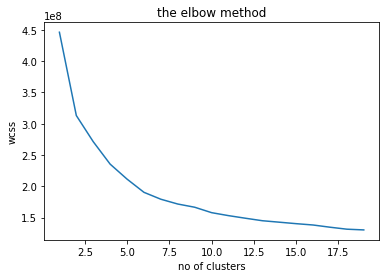

In [15]:
t0 = time()
#Training Kmeans
wcss_lemmad = [] #CHANGE
for i in range(1, 20): #max of 20 clusters otherwise might take too long
    kmeans_lem = KMeans(n_clusters = i, init='k-means++', max_iter = 300, n_init = 10, random_state = 0, verbose = True)
    kmeans_lem.fit(X_lemmad) #CHANGE
    wcss_lemmad.append(kmeans_lem.inertia_) #CHANGE
    
print("done in %fs" % (time() - t0))
    
#Visualisation of inertia (how far away the points within a cluster are, want small inertia)
pp.plot(range(1,20),wcss_lemmad[0:20]) #CHANGE
pp.title('the elbow method')
pp.xlabel('no of clusters')
pp.ylabel('wcss')
pp.show

## Using best k from elbow method on larger dataset

In [16]:
#applying K-means based on above elbow method, can change true_k to the desired number of clusters
true_k = 10
model_true = KMeans(n_clusters=true_k, init='k-means++', n_init=1)
model_true.fit(X_lemmad) #CHANGE

#Print results
print("top terms for cluster:")
order_centroids_lem = model_true.cluster_centers_.argsort()[:, ::-1]
terms_lem = cv_lem.get_feature_names()
for i in range(true_k):
    print("cluster %d:" % i),
    for ind in order_centroids_lem[i, :10]: #selects top terms
        print(' %s' % terms_lem[ind]),
    print
    
print("\n")

top terms for cluster:
cluster 0:
 company
 business
 product
 service
 may
 market
 customer
 including
 state
 also
cluster 1:
 new
 stylefontfamilytimes
 0pt
 spanptdtd
 romantimesseriffontsize12ptlineheight119margin0ptspan
 stylefontsize10ptvisibilityhidden
 3pt
 000000margin0ptpadding0ptp
 ptdtd
 romantimesseriffontsize10ptlineheight119textalignrightmargin0pt
cluster 2:
 lender
 loan
 credit
 shall
 agent
 section
 party
 agreement
 rate
 borrower
cluster 3:
 product
 may
 clinical
 trial
 patent
 patient
 drug
 fda
 approval
 candidate
cluster 4:
 loan
 bank
 company
 capital
 financial
 investment
 federal
 may
 institution
 asset
cluster 5:
 product
 clinical
 drug
 may
 fda
 patient
 trial
 patent
 approval
 study
cluster 6:
 2016
 2015
 31
 december
 year
 revenue
 expense
 generation
 2014
 ended
cluster 7:
 loan
 credit
 million
 financial
 interest
 31
 december
 capital
 2020
 rate
cluster 8:
 may
 million
 company
 result
 could
 financial
 business
 operation
 product
 

# Explaining Returns with Kmeans

## Get Features for S&P500

In [17]:
tf_sp50 = cv_lem.transform(lemmad_text_sp50)

features_sp50 = model_true.transform(tf_sp50)

features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)

## Loop Over Dates and Perform OLS Regression

In [18]:
all_dates = returns_sp50.index
max_f = 19
adj_r2_features = []

for dd in all_dates:
    reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
    y = reg_data[:, 0]
    X = reg_data[:, 1:]

    std_scaler = StandardScaler()
    X = std_scaler.fit_transform(X)

    X = sm.add_constant(X, prepend=False)
    ols_model = sm.OLS(y, X)
    res = ols_model.fit()
    adj_r2_features.append(res.rsquared_adj)

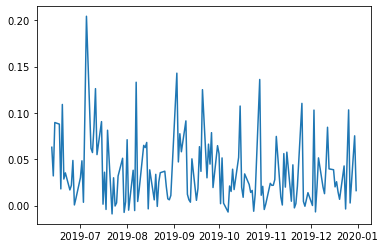

In [19]:
pp.plot(all_dates, adj_r2_features)

In [20]:
tf_sp50 = cv_lem.transform(lemmad_text_sp50)
all_ks = [5, 10, 15, 20, 25, 30, 40, 50]
num_trials = 20
all_adj_r2 = []
for k in all_ks:
    print(f'Running for k = {k}')
    adj_r2_k = []
    for t in range(num_trials):
        
        this_kmeans = KMeans(n_clusters = k, init='k-means++', n_init = 1, random_state = 0, verbose = True)
        this_kmeans.fit(X_lemmad)
        
        features_sp50 = this_kmeans.transform(tf_sp50)
        features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)
        
#         this_lda = LatentDirichletAllocation(n_components=k, max_iter=5,
#                                     learning_method='online',
#                                     learning_offset=50.)
#         this_lda.fit(tf)
    
#         features_sp50 = this_lda.transform(tf_sp50)
#         features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)
        adj_r2_dates = []
        for dd in all_dates:
            reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
            y = reg_data[:, 0]
            X = reg_data[:, 1:]

            std_scaler = StandardScaler()
            X = std_scaler.fit_transform(X)

            X = sm.add_constant(X, prepend=False)
            ols_model = sm.OLS(y, X)
            res = ols_model.fit()
            adj_r2_dates.append(res.rsquared_adj)
        adj_r2_k.append(np.mean(adj_r2_dates))
    all_adj_r2.append(adj_r2_k)

Running for k = 5
Initialization complete
Iteration 0, inertia 300860591.0
Iteration 1, inertia 215243615.6164639
Iteration 2, inertia 212300235.96151268
Iteration 3, inertia 212190478.71106136
Iteration 4, inertia 212171197.5053616
Iteration 5, inertia 212163072.36363918
Iteration 6, inertia 212162322.22743535
Converged at iteration 6: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 300860591.0
Iteration 1, inertia 215243615.6164639
Iteration 2, inertia 212300235.96151268
Iteration 3, inertia 212190478.71106136
Iteration 4, inertia 212171197.5053616
Iteration 5, inertia 212163072.36363918
Iteration 6, inertia 212162322.22743535
Converged at iteration 6: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 300860591.0
Iteration 1, inertia 215243615.6164639
Iteration 2, inertia 212300235.96151268
Iteration 3, inertia 212190478.71106136
Iteration 4, inertia 212171197.5053616
Iteration 5

Initialization complete
Iteration 0, inertia 261807576.0
Iteration 1, inertia 174209340.19177592
Iteration 2, inertia 169025340.5864833
Iteration 3, inertia 167948983.0863099
Iteration 4, inertia 165938602.97731072
Iteration 5, inertia 164067504.69687986
Iteration 6, inertia 163364598.48725283
Iteration 7, inertia 163222625.70036572
Iteration 8, inertia 163208273.99950004
Iteration 9, inertia 163206097.19749114
Iteration 10, inertia 163205388.81562814
Iteration 11, inertia 163205077.23120436
Iteration 12, inertia 163204852.05983368
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 261807576.0
Iteration 1, inertia 174209340.19177592
Iteration 2, inertia 169025340.5864833
Iteration 3, inertia 167948983.0863099
Iteration 4, inertia 165938602.97731072
Iteration 5, inertia 164067504.69687986
Iteration 6, inertia 163364598.48725283
Iteration 7, inertia 163222625.70036572
Iteration 8, inertia 163208273.99950004
Ite

Iteration 6, inertia 163364598.48725283
Iteration 7, inertia 163222625.70036572
Iteration 8, inertia 163208273.99950004
Iteration 9, inertia 163206097.19749114
Iteration 10, inertia 163205388.81562814
Iteration 11, inertia 163205077.23120436
Iteration 12, inertia 163204852.05983368
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 261807576.0
Iteration 1, inertia 174209340.19177592
Iteration 2, inertia 169025340.5864833
Iteration 3, inertia 167948983.0863099
Iteration 4, inertia 165938602.97731072
Iteration 5, inertia 164067504.69687986
Iteration 6, inertia 163364598.48725283
Iteration 7, inertia 163222625.70036572
Iteration 8, inertia 163208273.99950004
Iteration 9, inertia 163206097.19749114
Iteration 10, inertia 163205388.81562814
Iteration 11, inertia 163205077.23120436
Iteration 12, inertia 163204852.05983368
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initializat

Initialization complete
Iteration 0, inertia 210389642.0
Iteration 1, inertia 153533532.70648643
Iteration 2, inertia 151303746.53378373
Iteration 3, inertia 150223226.7921194
Iteration 4, inertia 149880018.3992207
Iteration 5, inertia 149782829.66336086
Iteration 6, inertia 149667997.38188472
Iteration 7, inertia 149538266.43771073
Iteration 8, inertia 149187580.72987384
Iteration 9, inertia 147051436.27488494
Iteration 10, inertia 146335834.32359278
Iteration 11, inertia 146205204.6739628
Iteration 12, inertia 146169298.58292034
Iteration 13, inertia 146166788.69786572
Iteration 14, inertia 146164312.79054803
Iteration 15, inertia 146163652.50578868
Iteration 16, inertia 146163507.55825695
Converged at iteration 16: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 210389642.0
Iteration 1, inertia 153533532.70648643
Iteration 2, inertia 151303746.53378373
Iteration 3, inertia 150223226.7921194
Iteration 4, inertia 149880018.3992207


Iteration 10, inertia 146335834.32359278
Iteration 11, inertia 146205204.6739628
Iteration 12, inertia 146169298.58292034
Iteration 13, inertia 146166788.69786572
Iteration 14, inertia 146164312.79054803
Iteration 15, inertia 146163652.50578868
Iteration 16, inertia 146163507.55825695
Converged at iteration 16: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 210389642.0
Iteration 1, inertia 153533532.70648643
Iteration 2, inertia 151303746.53378373
Iteration 3, inertia 150223226.7921194
Iteration 4, inertia 149880018.3992207
Iteration 5, inertia 149782829.66336086
Iteration 6, inertia 149667997.38188472
Iteration 7, inertia 149538266.43771073
Iteration 8, inertia 149187580.72987384
Iteration 9, inertia 147051436.27488494
Iteration 10, inertia 146335834.32359278
Iteration 11, inertia 146205204.6739628
Iteration 12, inertia 146169298.58292034
Iteration 13, inertia 146166788.69786572
Iteration 14, inertia 146164312.79054803
Iteration 1

Iteration 12, inertia 129566117.64754324
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 196086625.0
Iteration 1, inertia 137531728.93797007
Iteration 2, inertia 133339496.19847944
Iteration 3, inertia 130999963.79664831
Iteration 4, inertia 130299191.56804942
Iteration 5, inertia 130037001.79390012
Iteration 6, inertia 129879094.79745047
Iteration 7, inertia 129833201.45462738
Iteration 8, inertia 129603917.93683423
Iteration 9, inertia 129593852.1891742
Iteration 10, inertia 129582227.582722
Iteration 11, inertia 129572132.79647104
Iteration 12, inertia 129566117.64754324
Converged at iteration 12: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 196086625.0
Iteration 1, inertia 137531728.93797007
Iteration 2, inertia 133339496.19847944
Iteration 3, inertia 130999963.79664831
Iteration 4, inertia 130299191.56804942
Iteration 5, inertia 130037001.793900

Iteration 2, inertia 122820810.94776137
Iteration 3, inertia 122154575.06773858
Iteration 4, inertia 121895728.64063919
Iteration 5, inertia 121717421.51825534
Iteration 6, inertia 121654261.75952259
Iteration 7, inertia 121627873.48906553
Iteration 8, inertia 121577525.93545677
Iteration 9, inertia 121566079.37843616
Iteration 10, inertia 121561836.0591157
Iteration 11, inertia 121561357.11175868
Converged at iteration 11: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 167229021.0
Iteration 1, inertia 125060642.5998208
Iteration 2, inertia 122820810.94776137
Iteration 3, inertia 122154575.06773858
Iteration 4, inertia 121895728.64063919
Iteration 5, inertia 121717421.51825534
Iteration 6, inertia 121654261.75952259
Iteration 7, inertia 121627873.48906553
Iteration 8, inertia 121577525.93545677
Iteration 9, inertia 121566079.37843616
Iteration 10, inertia 121561836.0591157
Iteration 11, inertia 121561357.11175868
Converged at itera

Iteration 4, inertia 121895728.64063919
Iteration 5, inertia 121717421.51825534
Iteration 6, inertia 121654261.75952259
Iteration 7, inertia 121627873.48906553
Iteration 8, inertia 121577525.93545677
Iteration 9, inertia 121566079.37843616
Iteration 10, inertia 121561836.0591157
Iteration 11, inertia 121561357.11175868
Converged at iteration 11: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 167229021.0
Iteration 1, inertia 125060642.5998208
Iteration 2, inertia 122820810.94776137
Iteration 3, inertia 122154575.06773858
Iteration 4, inertia 121895728.64063919
Iteration 5, inertia 121717421.51825534
Iteration 6, inertia 121654261.75952259
Iteration 7, inertia 121627873.48906553
Iteration 8, inertia 121577525.93545677
Iteration 9, inertia 121566079.37843616
Iteration 10, inertia 121561836.0591157
Iteration 11, inertia 121561357.11175868
Converged at iteration 11: center shift 0.0 within tolerance 0.00013417720752205588
Initialization

Iteration 4, inertia 116666879.98809499
Iteration 5, inertia 116352316.4740524
Iteration 6, inertia 116249938.84328943
Iteration 7, inertia 116188173.59848583
Iteration 8, inertia 116095910.21106146
Iteration 9, inertia 116060351.5959057
Iteration 10, inertia 116037473.75132819
Iteration 11, inertia 116010387.4876184
Iteration 12, inertia 115977696.9673376
Iteration 13, inertia 115956765.52882002
Iteration 14, inertia 115937366.911056
Iteration 15, inertia 115915197.46700421
Iteration 16, inertia 115904218.71060587
Iteration 17, inertia 115900988.4998674
Iteration 18, inertia 115899266.0292225
Iteration 19, inertia 115897917.45391962
Iteration 20, inertia 115897692.9728873
Iteration 21, inertia 115897569.01572908
Converged at iteration 21: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 160568758.0
Iteration 1, inertia 120021030.4708946
Iteration 2, inertia 117666617.28735603
Iteration 3, inertia 117044842.9855341
Iteration 4, inert

Iteration 14, inertia 115937366.911056
Iteration 15, inertia 115915197.46700421
Iteration 16, inertia 115904218.71060587
Iteration 17, inertia 115900988.4998674
Iteration 18, inertia 115899266.0292225
Iteration 19, inertia 115897917.45391962
Iteration 20, inertia 115897692.9728873
Iteration 21, inertia 115897569.01572908
Converged at iteration 21: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 160568758.0
Iteration 1, inertia 120021030.4708946
Iteration 2, inertia 117666617.28735603
Iteration 3, inertia 117044842.9855341
Iteration 4, inertia 116666879.98809499
Iteration 5, inertia 116352316.4740524
Iteration 6, inertia 116249938.84328943
Iteration 7, inertia 116188173.59848583
Iteration 8, inertia 116095910.21106146
Iteration 9, inertia 116060351.5959057
Iteration 10, inertia 116037473.75132819
Iteration 11, inertia 116010387.4876184
Iteration 12, inertia 115977696.9673376
Iteration 13, inertia 115956765.52882002
Iteration 14, iner

Iteration 6, inertia 110153192.18748188
Iteration 7, inertia 110091278.67696626
Iteration 8, inertia 110030316.11421433
Iteration 9, inertia 109969743.43276845
Iteration 10, inertia 109941694.16942827
Iteration 11, inertia 109911496.6751157
Iteration 12, inertia 109905473.24754381
Iteration 13, inertia 109903073.81601556
Iteration 14, inertia 109902576.93391371
Iteration 15, inertia 109900745.62506577
Iteration 16, inertia 109900207.34029268
Iteration 17, inertia 109899731.43696629
Iteration 18, inertia 109898142.08595458
Converged at iteration 18: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 152240263.0
Iteration 1, inertia 113190171.64160813
Iteration 2, inertia 111312991.94181429
Iteration 3, inertia 110698477.74734406
Iteration 4, inertia 110433816.9218783
Iteration 5, inertia 110232666.92437291
Iteration 6, inertia 110153192.18748188
Iteration 7, inertia 110091278.67696626
Iteration 8, inertia 110030316.11421433
Iteration 9,

Iteration 16, inertia 109900207.34029268
Iteration 17, inertia 109899731.43696629
Iteration 18, inertia 109898142.08595458
Converged at iteration 18: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 152240263.0
Iteration 1, inertia 113190171.64160813
Iteration 2, inertia 111312991.94181429
Iteration 3, inertia 110698477.74734406
Iteration 4, inertia 110433816.9218783
Iteration 5, inertia 110232666.92437291
Iteration 6, inertia 110153192.18748188
Iteration 7, inertia 110091278.67696626
Iteration 8, inertia 110030316.11421433
Iteration 9, inertia 109969743.43276845
Iteration 10, inertia 109941694.16942827
Iteration 11, inertia 109911496.6751157
Iteration 12, inertia 109905473.24754381
Iteration 13, inertia 109903073.81601556
Iteration 14, inertia 109902576.93391371
Iteration 15, inertia 109900745.62506577
Iteration 16, inertia 109900207.34029268
Iteration 17, inertia 109899731.43696629
Iteration 18, inertia 109898142.08595458
Converged

Iteration 10, inertia 102951103.0279273
Iteration 11, inertia 102887154.35791717
Iteration 12, inertia 102832211.41318642
Iteration 13, inertia 102827054.79341266
Iteration 14, inertia 102826386.90053296
Iteration 15, inertia 102825915.20095599
Converged at iteration 15: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 142470304.0
Iteration 1, inertia 106780798.83930771
Iteration 2, inertia 104552101.27856015
Iteration 3, inertia 103835648.8659414
Iteration 4, inertia 103428044.11051683
Iteration 5, inertia 103259505.2876729
Iteration 6, inertia 103188551.57123949
Iteration 7, inertia 103141844.5423482
Iteration 8, inertia 103086892.6523094
Iteration 9, inertia 103001163.69100179
Iteration 10, inertia 102951103.0279273
Iteration 11, inertia 102887154.35791717
Iteration 12, inertia 102832211.41318642
Iteration 13, inertia 102827054.79341266
Iteration 14, inertia 102826386.90053296
Iteration 15, inertia 102825915.20095599
Converged at 

Iteration 11, inertia 102887154.35791717
Iteration 12, inertia 102832211.41318642
Iteration 13, inertia 102827054.79341266
Iteration 14, inertia 102826386.90053296
Iteration 15, inertia 102825915.20095599
Converged at iteration 15: center shift 0.0 within tolerance 0.00013417720752205588
Initialization complete
Iteration 0, inertia 142470304.0
Iteration 1, inertia 106780798.83930771
Iteration 2, inertia 104552101.27856015
Iteration 3, inertia 103835648.8659414
Iteration 4, inertia 103428044.11051683
Iteration 5, inertia 103259505.2876729
Iteration 6, inertia 103188551.57123949
Iteration 7, inertia 103141844.5423482
Iteration 8, inertia 103086892.6523094
Iteration 9, inertia 103001163.69100179
Iteration 10, inertia 102951103.0279273
Iteration 11, inertia 102887154.35791717
Iteration 12, inertia 102832211.41318642
Iteration 13, inertia 102827054.79341266
Iteration 14, inertia 102826386.90053296
Iteration 15, inertia 102825915.20095599
Converged at iteration 15: center shift 0.0 within to

In [21]:
[np.mean(x) for x in all_adj_r2]

[0.022890475248756766,
 0.042501880123144736,
 0.054114088104266864,
 0.06843872107909288,
 0.07999863450735294,
 0.07931403533520529,
 0.0786392100809797,
 0.06920233408958444]

In [22]:
[np.std(x) for x in all_adj_r2]

[3.469446951953614e-18,
 6.938893903907228e-18,
 6.938893903907228e-18,
 0.0,
 1.3877787807814457e-17,
 1.3877787807814457e-17,
 1.3877787807814457e-17,
 0.0]